<a href="https://colab.research.google.com/github/shubham7423/Add/blob/master/Masked_Unmasked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Nov  5 02:09:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!unzip /content/masked_unmasked.zip

Streaming output truncated to the last 5000 lines.
  inflating: masked_unmasked/unmasked/9_1_2_20161219204347420.jpg.chip.jpg  
  inflating: __MACOSX/masked_unmasked/unmasked/._9_1_2_20161219204347420.jpg.chip.jpg  
  inflating: masked_unmasked/unmasked/36_0_1_20170117163203851.jpg.chip.jpg  
  inflating: __MACOSX/masked_unmasked/unmasked/._36_0_1_20170117163203851.jpg.chip.jpg  
  inflating: masked_unmasked/unmasked/86_1_0_20170120225751953.jpg.chip.jpg  
  inflating: __MACOSX/masked_unmasked/unmasked/._86_1_0_20170120225751953.jpg.chip.jpg  
  inflating: masked_unmasked/unmasked/26_1_0_20170116171048641.jpg.chip.jpg  
  inflating: __MACOSX/masked_unmasked/unmasked/._26_1_0_20170116171048641.jpg.chip.jpg  
  inflating: masked_unmasked/unmasked/1_1_2_20161219154612988.jpg.chip.jpg  
  inflating: __MACOSX/masked_unmasked/unmasked/._1_1_2_20161219154612988.jpg.chip.jpg  
  inflating: masked_unmasked/unmasked/52_0_1_20170117161018159.jpg.chip.jpg  
  inflating: __MACOSX/masked_unmasked/un

In [3]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from sklearn.model_selection import train_test_split

In [4]:
CFG = {
    'train_BS': 64,
    'valid_BS': 64,
    'lr': 0.002,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [22]:
data = pd.read_csv('/content/masked_unmasked/data.csv')
data = data.drop(data[data['image'] == "masked/.DS_Store"].index)

train, valid = train_test_split(data, test_size=0.15, random_state=42)

In [23]:
data.shape

(4698, 2)

In [24]:
class MaskDataset(torch.utils.data.Dataset):
    def __init__ (self, csv_data, images_path, transform=None):
        self.csv_data = csv_data
        self.transform = transform
        self.images_path = images_path
    
    def __len__ (self):
        return self.csv_data.shape[0]
    
    def __getitem__ (self, idx):
        label = 1 if self.csv_data.iloc[idx, 1] == "masked" else 0
        image = cv2.imread(os.path.join(self.images_path, self.csv_data.iloc[idx, 0]))
        if image is None:
            print(idx)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [25]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(0.2),
     transforms.Resize((224, 224)),
     transforms.Normalize(mean=[0.485, 0.455, 0.406], std=[0.225, 0.225, 0.225])]
)

train_data = MaskDataset(train, '/content/masked_unmasked', transform=transform)
valid_data = MaskDataset(valid, '/content/masked_unmasked', transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG['train_BS'], shuffle=True, pin_memory=False)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=CFG['valid_BS'], shuffle=False, pin_memory=False)

In [26]:
import os
import torch
import torch.nn as nn
import numpy as np
import tqdm.notebook as tq
from sklearn.metrics import accuracy_score

class Train:
    def __init__ (self, model, device, optimizer, criterion, scheduler=None):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion.to(self.device)
        self.model.to(self.device)
        self.scheduler = scheduler
        # self.x = []

    def train (self, train_loader, epoch, n_examples):
        self.model.train()
        # training_loss = 0
        losses = []
        predicts = []
        correct = []
        description = "\nEPOCH: {} training".format(epoch+1)
        train_bar = tq.tqdm(train_loader, total=len(train_loader), desc=description, position=0, leave=True)
        for images, labels in train_bar:
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(images)
            loss = self.criterion(output, labels)

            correct.extend(labels.cpu().numpy())
            predicts.extend(torch.argmax(output, dim=1).cpu().numpy())
            losses.append(loss.item())

            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.optimizer.zero_grad()
  
            train_bar.set_postfix(loss=np.mean(losses))
        return np.mean(losses), accuracy_score(predicts, correct)

    def val (self, val_loader, epoch, n_examples):
        self.model.eval()
        losses = []
        predicts = []
        correct = []
        description = "EPOCH: {} validation".format(epoch+1)
        with torch.no_grad():
            valid_bar = tq.tqdm(val_loader, total=len(val_loader), desc=description, position=0, leave=True)
            for images, labels in valid_bar:

                images, labels = images.to(self.device), labels.to(self.device)
                output = self.model(images)
                loss = self.criterion(output, labels)

                correct.extend(labels.cpu().numpy())
                predicts.extend(torch.argmax(output, dim=1).cpu().numpy())

                losses.append(loss.item())
                valid_bar.set_postfix(loss=np.mean(losses))

        return np.mean(losses), accuracy_score(predicts, correct)


    def fit(self, ES, model_path, train_loader, val_loader=None, epochs=1, start_epoch=0, fold=0, train_BS=64, valid_BS=64):
        
        training_loss_lst = []
        training_acc_lst = []
        val_loss_lst = []
        val_acc_lst = []
        i = 0
        validation = False

        # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
        if val_loader is not None:
            validation = True
            # val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

        # print("=> Trining Model on: {}\n\n".format(self.device))
        min_loss = np.Inf
        for epoch in range(start_epoch, epochs):
            
            training_loss, training_acc = self.train(train_loader, epoch, len(train_loader)*train_BS)
            training_acc_lst.append(training_loss)
            training_acc_lst.append(training_acc)
            
            if validation:
                val_loss, val_acc = self.val(val_loader, epoch, len(val_loader)*valid_BS)
                val_loss_lst.append(val_loss)
                val_acc_lst.append(val_acc)

                # self.x.append([training_loss, training_acc, val_loss, val_acc])
                print('Train Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f}'.format(training_loss, training_acc, val_loss, val_acc))
                i += 1
                if i > ES:
                    print('\nEarly Stopping')
                    break
                if val_loss <= min_loss:
                    i = 0
                    if self.scheduler is not None:
                        checkpoint = {
                              'epoch': epoch + 1,
                              'model': self.model.state_dict(),
                              'optimizer': self.optimizer.state_dict(),
                              'scheduler': self.scheduler.state_dict()
                          }
                    else:
                        checkpoint = {
                              'epoch': epoch + 1,
                              'model': self.model.state_dict(),
                              'optimizer': self.optimizer.state_dict()
                          }
                    

                    model_path_1 = os.path.join(model_path, 'model_fold{}.pt'.format(fold))
                    torch.save(checkpoint, model_path_1)
                    print('\nVal loss decreased ({:.4f} -> {:.4f}), Model saved'.format(min_loss, val_loss))
                    min_loss = val_loss
                    
            
            else:
                print('EPOCH: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} '.format(epoch+1, training_loss, training_acc))
                i += 1
                if i >= ES:
                    print('Early Stopping')
                    break
                if training_loss <= min_loss:
                    i = 0
                    print('Loss decreased ({:.4f} -> {:.4f}), model saved at {}'.format(min_loss, training_loss, model_path))
                    min_loss = training_loss

                    if self.scheduler is not None:
                        checkpoint = {
                            'epoch': epoch + 1,
                            'model': self.model.state_dict(),
                            'optimizer': self.optimizer.state_dict(),
                            'scheduler': self.scheduler.state_dict()
                        }
                    else:
                        checkpoint = {
                        'epoch': epoch + 1,
                        'model': self.model.state_dict(),
                        'optimizer': self.optimizer.state_dict()
                    }
                    model_path_1 = '{}model_{}.pt'.format(model_path, epoch+1)
                    torch.save(checkpoint, model_path_1)
            
            if self.scheduler is not None:
                self.scheduler.step()

            torch.cuda.empty_cache()

        history = {
            'train_loss': training_loss_lst,
            'train_acc': training_acc_lst,
            'val_loss': val_loss_lst,
            'val_acc': val_acc_lst
        }

        return history   

In [27]:
class MaskClassifierResnet50(nn.Module):
    def __init__ (self, opt_class):
        super().__init__ ()
        self.resnet = torchvision.models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, opt_class)
    
    def forward (self, image):
        return self.resnet(image)

In [28]:
model = MaskClassifierResnet50(2)
model = model.to(CFG['device'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=CFG['lr'])

In [29]:
trainer = Train(model=model, device=CFG['device'], optimizer=optimizer, criterion=criterion)

In [30]:
trainer.fit(ES=3, model_path='../content', train_loader=train_loader, val_loader=valid_loader, epochs=20, start_epoch=0, fold=0)


EPOCH: 1 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 1 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.6069 	Train Acc: 0.7320 	Val Loss: 0.4844 	Val Acc: 0.9418

Val loss decreased (inf -> 0.4844), Model saved



EPOCH: 2 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 2 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.4037 	Train Acc: 0.9612 	Val Loss: 0.3159 	Val Acc: 0.9844

Val loss decreased (0.4844 -> 0.3159), Model saved



EPOCH: 3 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 3 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.2628 	Train Acc: 0.9882 	Val Loss: 0.2072 	Val Acc: 0.9872

Val loss decreased (0.3159 -> 0.2072), Model saved



EPOCH: 4 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 4 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.1714 	Train Acc: 0.9925 	Val Loss: 0.1323 	Val Acc: 0.9929

Val loss decreased (0.2072 -> 0.1323), Model saved



EPOCH: 5 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 5 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.1077 	Train Acc: 0.9955 	Val Loss: 0.0850 	Val Acc: 0.9929

Val loss decreased (0.1323 -> 0.0850), Model saved



EPOCH: 6 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 6 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0744 	Train Acc: 0.9967 	Val Loss: 0.0556 	Val Acc: 0.9957

Val loss decreased (0.0850 -> 0.0556), Model saved



EPOCH: 7 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 7 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0493 	Train Acc: 0.9975 	Val Loss: 0.0413 	Val Acc: 0.9972

Val loss decreased (0.0556 -> 0.0413), Model saved



EPOCH: 8 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 8 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0397 	Train Acc: 0.9972 	Val Loss: 0.0309 	Val Acc: 0.9972

Val loss decreased (0.0413 -> 0.0309), Model saved



EPOCH: 9 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 9 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0308 	Train Acc: 0.9972 	Val Loss: 0.0236 	Val Acc: 0.9986

Val loss decreased (0.0309 -> 0.0236), Model saved



EPOCH: 10 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 10 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0268 	Train Acc: 0.9970 	Val Loss: 0.0202 	Val Acc: 0.9972

Val loss decreased (0.0236 -> 0.0202), Model saved



EPOCH: 11 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 11 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0192 	Train Acc: 0.9987 	Val Loss: 0.0179 	Val Acc: 0.9986

Val loss decreased (0.0202 -> 0.0179), Model saved



EPOCH: 12 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 12 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0176 	Train Acc: 0.9977 	Val Loss: 0.0138 	Val Acc: 0.9972

Val loss decreased (0.0179 -> 0.0138), Model saved



EPOCH: 13 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 13 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0153 	Train Acc: 0.9985 	Val Loss: 0.0129 	Val Acc: 0.9972

Val loss decreased (0.0138 -> 0.0129), Model saved



EPOCH: 14 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 14 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0146 	Train Acc: 0.9985 	Val Loss: 0.0125 	Val Acc: 0.9972

Val loss decreased (0.0129 -> 0.0125), Model saved



EPOCH: 15 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 15 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0123 	Train Acc: 0.9995 	Val Loss: 0.0101 	Val Acc: 1.0000

Val loss decreased (0.0125 -> 0.0101), Model saved



EPOCH: 16 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 16 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0112 	Train Acc: 0.9987 	Val Loss: 0.0098 	Val Acc: 1.0000

Val loss decreased (0.0101 -> 0.0098), Model saved



EPOCH: 17 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 17 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0106 	Train Acc: 0.9987 	Val Loss: 0.0087 	Val Acc: 0.9986

Val loss decreased (0.0098 -> 0.0087), Model saved



EPOCH: 18 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 18 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0094 	Train Acc: 0.9985 	Val Loss: 0.0086 	Val Acc: 0.9972

Val loss decreased (0.0087 -> 0.0086), Model saved



EPOCH: 19 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 19 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0083 	Train Acc: 0.9990 	Val Loss: 0.0074 	Val Acc: 0.9986

Val loss decreased (0.0086 -> 0.0074), Model saved



EPOCH: 20 training:   0%|          | 0/63 [00:00<?, ?it/s]

EPOCH: 20 validation:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.0084 	Train Acc: 0.9997 	Val Loss: 0.0073 	Val Acc: 1.0000

Val loss decreased (0.0074 -> 0.0073), Model saved


{'train_acc': [0.6068512887235672,
  0.732031054345104,
  0.403654346390376,
  0.9611820686200852,
  0.2627757823183423,
  0.9882294014525419,
  0.17136383541519679,
  0.9924868519909842,
  0.10766652155490149,
  0.9954921111945906,
  0.07439379766583443,
  0.9967443025294265,
  0.04928653013138544,
  0.9974956173303281,
  0.03972625702856079,
  0.9972451790633609,
  0.030797237752094156,
  0.9972451790633609,
  0.026832896609982802,
  0.9969947407963937,
  0.01923289872883331,
  0.998747808665164,
  0.01760460516171796,
  0.9977460555972952,
  0.015276105468353582,
  0.9984973703981969,
  0.014601573126301878,
  0.9984973703981969,
  0.01230288804730489,
  0.9994991234660656,
  0.01118463445602665,
  0.998747808665164,
  0.010571440504420371,
  0.998747808665164,
  0.009404173867392635,
  0.9984973703981969,
  0.008288966137028876,
  0.9989982469321312,
  0.00841600746877255,
  0.9997495617330328],
 'train_loss': [],
 'val_acc': [0.9418439716312057,
  0.9843971631205674,
  0.987234042

In [31]:
def pred_label(img, model):
    img = cv2.resize(img, (224, 224))
    img = transform(img)

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(CFG['device']))
    print(pred)
    return pred.argmax(1)

tensor([[ 1.9087, -1.6779]], device='cuda:0')


tensor([0], device='cuda:0')

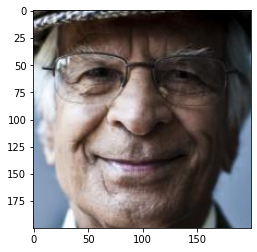

In [41]:
img = cv2.imread('/content/75_0_0_20170111204851535.jpg.chip.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pred_label(img, model)